1. 이미지 이진화
2. 사이즈 통일

In [ ]:
# 구글 드라이브 사용 권한 설정
import os
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import os
import random
import numpy as np
import matplotlib.pyplot as plt

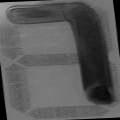

(120, 120)

In [ ]:
tmp = '/gdrive/MyDrive/Colab Notebooks/Capstone/labeling_crop_train/99_crop_2375_1639_140_232_aug_3811_0.jpg'
tmp = cv2.imread(tmp)
tmp = cv2.resize(tmp,(120,120))
gray = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
# for idx,i in enumerate(gray):
#   for id,j in enumerate(i):
#     if j == 0 :
#       gray[idx][id] = 255
cv2_imshow(gray)
gray.shape

In [ ]:
# ### mnist data ####


# from tensorflow.keras import datasets

# mnist = datasets.mnist

# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train, X_test = X_train / 255.0, X_test / 255.0

# X_train = X_train.reshape((60000, 28 ,28, 1))
# X_test = X_test.reshape((10000, 28 ,28, 1))

In [ ]:
# plt.imshow(X_train[1].reshape(28,28))
# print(y_train[1])

In [ ]:
import os
from PIL import Image
import numpy as np

gt_path = '/gdrive/MyDrive/Colab Notebooks/Capstone/labeling_crop_train/gt.txt'

X_train = []
y_train = []
with open(gt_path, "r") as f:
  for line in f:
    img_file, label = line.strip().split("\t")
    img = Image.open('/gdrive/MyDrive/Colab Notebooks/Capstone/'+img_file)
    img = img.resize((32,32))
    img_array = np.array(img)
    X_train.append(img_array)
    y_train.append(label)


15300
(32, 32, 3)
9


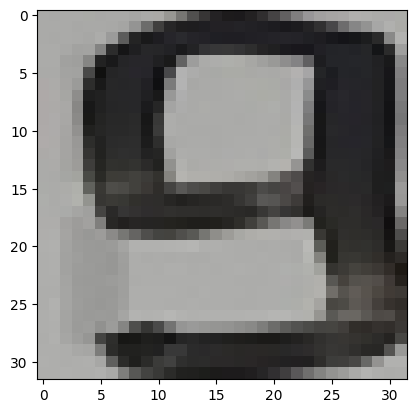

In [ ]:
print(len(X_train))
print(X_train[1].shape)
plt.imshow(X_train[1])
print(y_train[1])

In [ ]:
gt_path = '/gdrive/MyDrive/Colab Notebooks/Capstone/labeling_crop_valid/gt.txt'

X_test = []
y_test = []
with open(gt_path, "r") as f:
  for line in f:
    img_file, label = line.strip().split("\t")
    img = Image.open('/gdrive/MyDrive/Colab Notebooks/Capstone/'+img_file)
    img = img.resize((32,32))
    img_array = np.array(img)
    X_test.append(img_array)
    y_test.append(label)

931
(32, 32, 3)
4


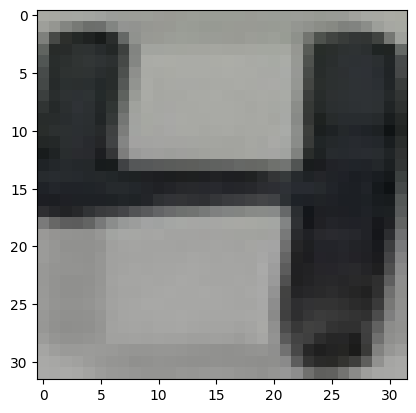

In [ ]:
print(len(X_test))
print(X_test[1].shape)
plt.imshow(X_test[1])
print(y_test[1])

In [ ]:
###  NULL 제거 # 실수 제거 # 10 이상 수 제거
for i,x in enumerate(y_train):
  if x == 'NULL' :
    del y_train[i]
    del X_train[i]

for i,x in enumerate(y_test):
  if x == 'NULL' :
    del y_test[i]
    del X_test[i]



In [ ]:
# 실수 제거
for i,x in enumerate(y_train):
  if x.find('.') != -1 :
    del y_train[i]
    del X_train[i]

for i,x in enumerate(y_test):
  if x.find('.') != -1 :
    del y_test[i]
    del X_test[i]



In [ ]:
# 10 이상 수 제거
for i,x in enumerate(y_train):
  if int(x) >= 10 :
    del y_train[i]
    del X_train[i]

for i,x in enumerate(y_test):
  if int(x) >= 10 :
    del y_test[i]
    del X_test[i]

In [ ]:
# 확인
for i,x in enumerate(y_train):
  if x == 'NULL' or x.find('.') != -1 or int(x) >= 10:
    print(str(i))

for i,x in enumerate(y_test):
  if x == 'NULL' or x.find('.') != -1 or int(x) >= 10 :
    print(str(i))

In [ ]:
######################################################################################################################################################

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                  padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    # layers.Dense(10000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 flatten_9 (Flatten)         (None, 4096)             

In [ ]:
X_train_rgb = []

for img in X_train:
    if len(img.shape) == 2:  # grayscale image
        rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        X_train_rgb.append(rgb_img)
    else:                    # color image
        X_train_rgb.append(img)

# Convert the list to a numpy array
X_train = np.array(X_train_rgb)

In [ ]:
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# X_train, X_test = X_train / 255.0, X_test / 255.0

# X_train = X_train.reshape((15300, 120 ,120, 1))
# X_test = X_test.reshape((931, 120 ,120, 1))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13504, 32, 32, 3)
(13504,)
(845, 32, 32, 3)
(845,)


In [ ]:
y_train =  np.array(y_train).astype(np.int)
y_test =  np.array(y_test).astype(np.int)
# int_array = np.array(str_list).astype(np.int)

<ipython-input-236-04ca469d310a>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train =  np.array(y_train).astype(np.int)
<ipython-input-236-04ca469d310a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 

In [ ]:
import time

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

hist = model.fit(X_train, y_train, epochs=5, verbose = 1, validation_data=(X_test, y_test))
# hist = model.fit(X_train, y_train_encoded, epochs=5, verbose=1, validation_data=(X_test, y_test))

print(f'Fit Time :{time.time() - start_time}')

Epoch 1/5
422/422 [==============================] - 51s 117ms/step - loss: 4.6758 - accuracy: 0.8990 - val_loss: 0.0939 - val_accuracy: 0.9822
Epoch 2/5
422/422 [==============================] - 49s 115ms/step - loss: 0.0757 - accuracy: 0.9785 - val_loss: 0.0831 - val_accuracy: 0.9917
Epoch 3/5
422/422 [==============================] - 48s 114ms/step - loss: 0.0721 - accuracy: 0.9793 - val_loss: 0.0916 - val_accuracy: 0.9929
Epoch 4/5
422/422 [==============================] - 47s 111ms/step - loss: 0.0681 - accuracy: 0.9822 - val_loss: 0.1100 - val_accuracy: 0.9929
Epoch 5/5
422/422 [==============================] - 47s 112ms/step - loss: 0.0356 - accuracy: 0.9907 - val_loss: 0.1087 - val_accuracy: 0.9941
Fit Time :263.4326162338257


In [ ]:
#저장
model.save('/gdrive/MyDrive/Colab Notebooks/Capstone/CNN_my_model')

In [ ]:
## 틀린숫자 확인 /
## 모델 바로 수행하는거